<h2>Obtenção de Tendências em Séries Temporais utilizando Transformada Wavelet</h2>
<p>Exemplo de uma série temporal e da curva de tendência estimada<br><img src="exemplos/apresentacao/img_tendencia.png"></p><br>
<h3>Série Temporal</h3>
<p>Dado um processo estocástico $x(t, \omega), t \ Z$ definido no espaço $Z \times \Omega$, <b>uma série temporal</b> é uma realização desse processo estocástico, onde $x(t, \omega)$ é uma variável aleatória no espaço de probabilidades $(\Omega, \mathcal{A}, P)$ para um dado índice $t$ e um evento elementar $\omega$, sendo $\Omega$ o conjunto dos eventos elementares possível e $\mathcal{A}$ a coleção dos subconjuntos $A \in \Omega$; $P$ é uma função de probebilidade e $Z=\lbrace 0,1,2,\cdots \rbrace$ um conjunto de índices.<br><br>
<b>Uma série temporal</b> pode ser escrita como a composição de uma tendência $u(t)$ mais uma sazonalidade cíclica $s(t)$ e algum ruído $\epsilon(t)$:</p><br>
$$
x(t) = u(t) + s(t) + \epsilon(t)
$$
<h3>Transformada Wavelet Discreta (Discrete Wavelet Transform - DWT)</h3>
<img src="exemplos/apresentacao/banco_filtros.png">
<p>No domínio da frequência, a aplicação da DWT resulta nas seguintes distribuições de frequências.</p>
<img src="exemplos/apresentacao/freq.png">
<p>Essa abordagem envolve a obtenção dos coeficientes de aproximação que representam as mudanças suaves da série temporal que são representações da tendência.</p>
<p>Dada uma série temporal $x(t)$, está pode ser escrita como uma sobreposição de coeficientes de aproximação $cA^j$ e detalhes $cD^j$ multiplicados pelas função de escala $\phi_j(t)$ e wavelet $\psi_j(t)$ em escalas $j$ distintas, de acordo com a equação:</p><br>
$$
x(t) = \sum_{n} cA^{J}[n]\phi_{J,n}(t) + \sum_{j \leq J}\sum_{n} cD^{j}[n]\psi_{j,n}(t)
$$
<br><p>onde temos que os coeficientes característicos, para $n$ inteiro, são dados por:</p><br>
$$
cA^{j}[n] = \langle x(t), \phi_{j,n}(t) \rangle
$$
<br>
$$
cD^{j}[n] = \langle x(t), \psi_{j,n}(t) \rangle
$$
<br>
<p>Para saber o nível máximo $J$ que podemos decompor a série, devemos aplicar a fórmula:</p><br>
$$
J = \lfloor \log_2 \left( \frac{N}{M− 1} \right) \rfloor
$$
<br><p>onde $N$ é q quantidade de amostras da série e $M$ o tamanho do filtros wavelet.</p>

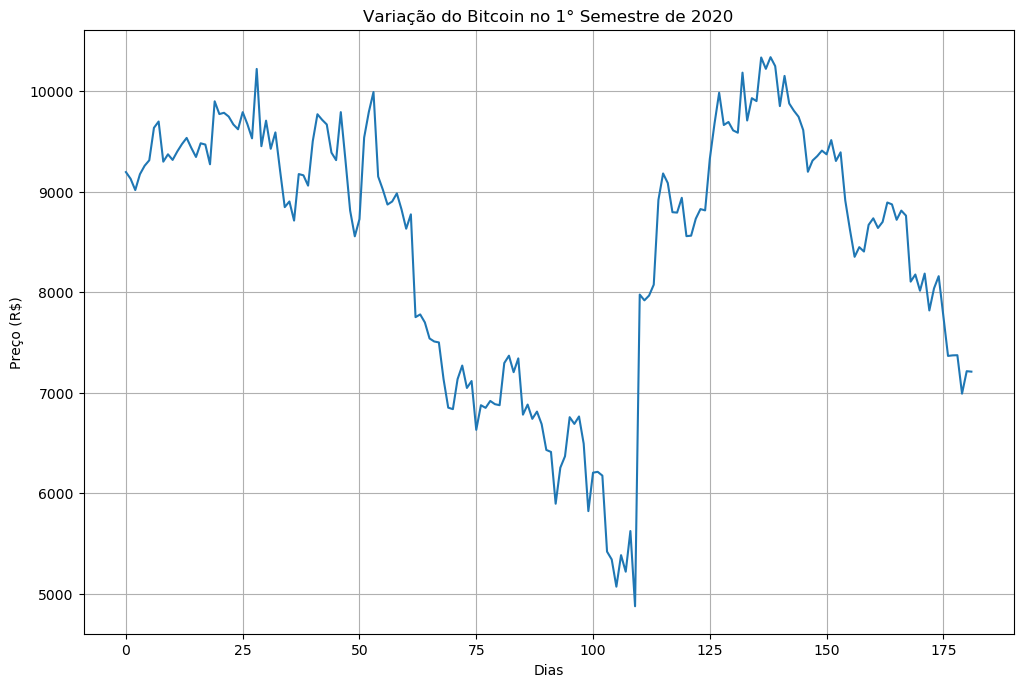

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Carrega a série de dados temporais (Preço de abertura do Bitcoin no primeiro semetres de 2020)
df = pd.read_csv('exemplos/dados_btc.csv')
serie_btc = df['Abertura']

plt.figure(dpi=100,figsize=(12,8))
plt.title('Variação do Bitcoin no 1° Semestre de 2020')
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.plot(serie_btc)
plt.grid()
plt.show()

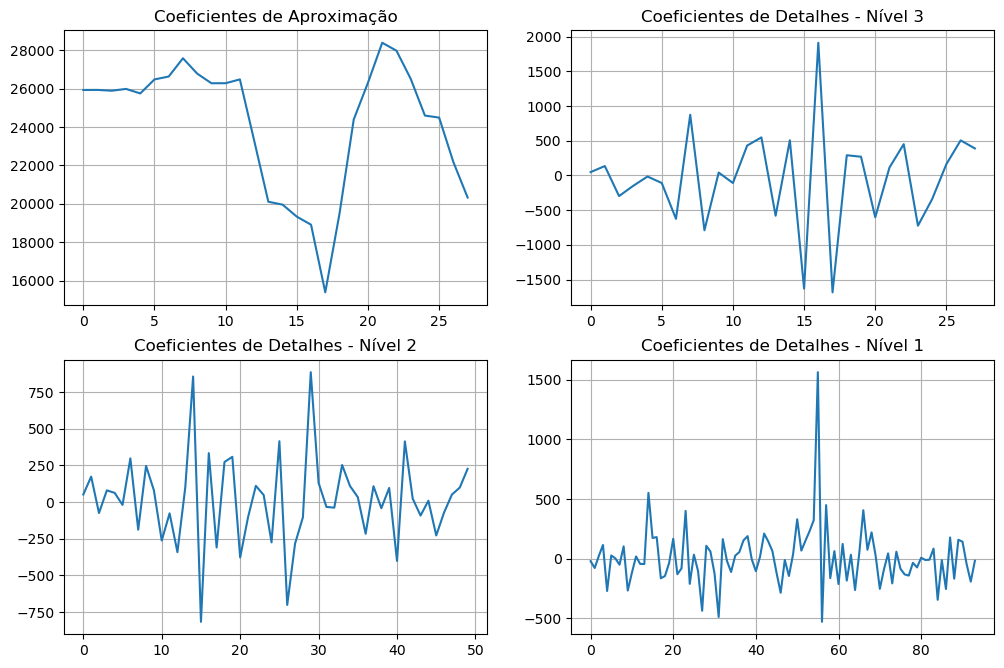

In [32]:
#Implementa a DWT (PyWavelets)
import pywt

wavelet = pywt.Wavelet('db4')
coeffs  = pywt.wavedec(serie_btc, wavelet, level=3)

#Mostra o último nível de aproximação
plt.figure(dpi=100,figsize=(12,8))
plt.subplot(221)
plt.plot(coeffs[0])
plt.title('Coeficientes de Aproximação')
plt.grid()
plt.subplot(222)
plt.plot(coeffs[1])
plt.title('Coeficientes de Detalhes - Nível 3')
plt.grid()
plt.subplot(223)
plt.plot(coeffs[2])
plt.title('Coeficientes de Detalhes - Nível 2')
plt.grid()
plt.subplot(224)
plt.plot(coeffs[3])
plt.title('Coeficientes de Detalhes - Nível 1')
plt.grid()
plt.show()
    

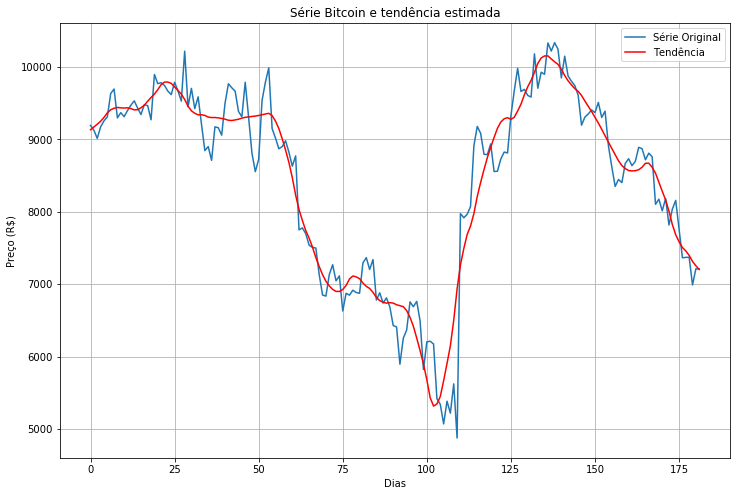

In [33]:
#Sintetiza (reconstrói) a série sem os coeficientes de detalhes
for j in range(1, len(coeffs)):
    coeffs[j] *= 0
    
tendencia_estimada = pywt.waverec(coeffs, wavelet)

#exibe a série original e a serie reconstruída, que representa a tendência da série original, 
#pois esta é a componente de baixa frequência

plt.figure(figsize=(12,8))
plt.plot(serie_btc, label='Série Original')
plt.plot(tendencia_estimada, label='Tendência', color='red')
plt.title('Série Bitcoin e tendência estimada')
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.legend()
plt.grid()
plt.show()

<h2>Considerando a série com ruído branco</h2>
<p>Neste exemplo verificamos como a curva de tendência é alterada caso se considera ruído branco adicionado a série original</p>

Erros
DWT:  18408.859788764144
MV:  11174.595027734276


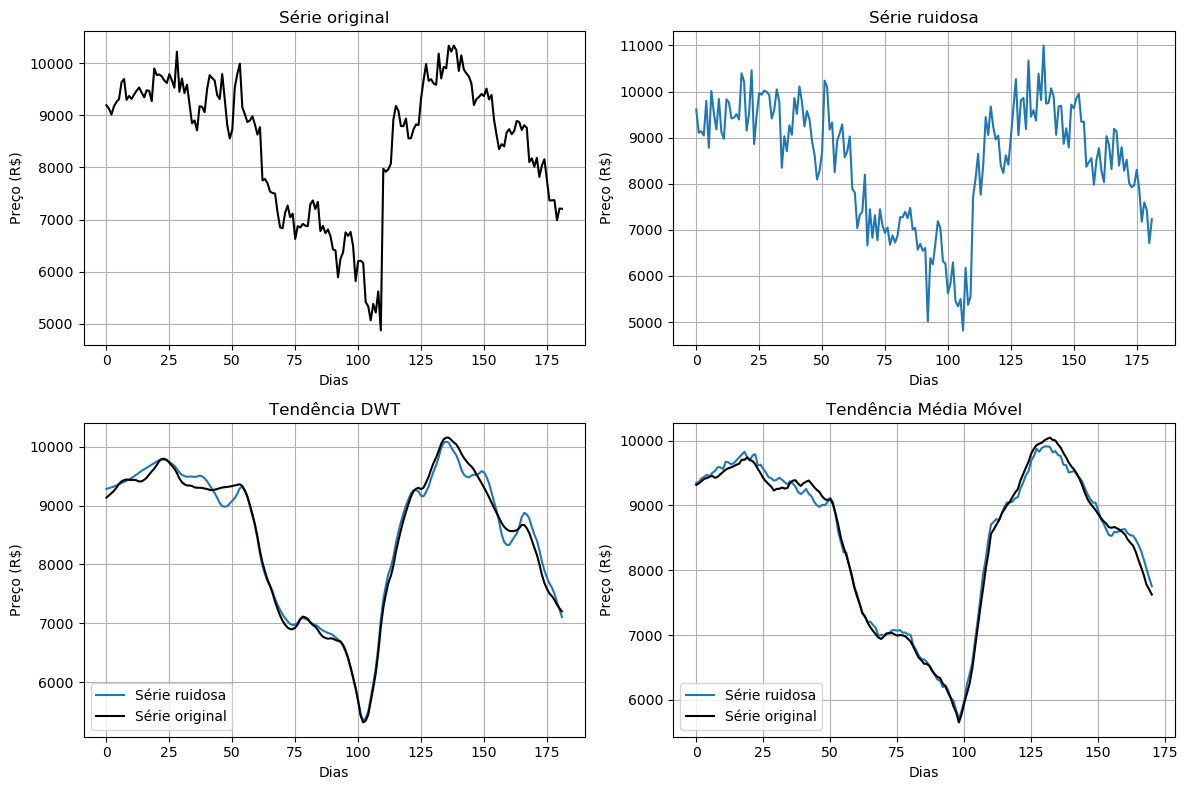

In [25]:
#Cria um ruído branco
ruido = np.random.normal(0, 1, len(serie_btc))

serie_ruidosa_btc = serie_btc + ruido * 400

#Decompões o sinal pela DWT
wavelet = pywt.Wavelet('db4')
coeffs  = pywt.wavedec(serie_ruidosa_btc, wavelet, level=3)

#Zera os coeficientes de detalhes
for j in range(1, len(coeffs)):
    coeffs[j] *= 0

#Sintetiza a série temporal com os coeficientes encolhidos
tendencia_estimada_ruidosa = pywt.waverec(coeffs, wavelet)

'''
Implementa uma média móvel apenas para comparação
'''
wz = 12 #tamanho da janela de análise
mv_ruidosa = pd.Series(serie_ruidosa_btc).rolling(wz).mean().tolist()
mv_ruidosa = mv_ruidosa[wz - 1: len(serie_ruidosa_btc) + wz]

#Implementa para a séria original sem ruído também
#A fim de verificar como o ruído afeta a estimação
mv = pd.Series(serie_btc).rolling(wz).mean().tolist()
mv = mv[wz - 1: len(serie_btc) + wz]

#Calcula o erro médio quadrático de estimação devido ao ruído
erro_dwt = (np.sum(np.abs(np.array(tendencia_estimada_ruidosa) - np.array(tendencia_estimada))**2))/len(tendencia_estimada_ruidosa)
erro_mv = (np.sum(np.abs(np.array(mv_ruidosa) - np.array(mv))**2))/len(mv)

print('Erros')
print('DWT: ', erro_dwt)
print('MV: ', erro_mv)

#exibe a série original e a serie reconstruída, que representa a tendência da série original, 
#pois esta é a componente de baixa frequência
plt.figure(dpi=100, figsize=(12,8))
plt.subplot(221)
plt.title('Série original')
plt.plot(serie_btc, color='k')
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.grid()
plt.subplot(222)
plt.title('Série ruidosa')
plt.plot(serie_ruidosa_btc)
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.grid()
plt.subplot(223)
plt.title('Tendência DWT')
plt.plot(tendencia_estimada_ruidosa, label='Série ruidosa')
plt.plot(tendencia_estimada, color='k', label='Série original')
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.legend()
plt.grid()
plt.subplot(224)
plt.title('Tendência Média Móvel')
plt.plot(mv_ruidosa, label='Série ruidosa')
plt.plot(mv, color='k', label='Série original')
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<h3>Removendo a tendência da série</h3>
<p>Isto ajuda a destacar sazonalidades e também é um dos passos para tornar a série estacionária.</p>
<p>Vamos analisar a série Air Passengers, que possui $144$ amostras mensais da quantidade de passageiros da aviação.</p>
<p>Podemos truncar a série para que tenha apenas $128$ amostras, pois este valor pode ser escrito na base $2$, isto é: $128 = 2^7$.</p>
<p>Cada nível de decomposição da DWT analisa a série em uma escala diferente. Para entender o significado, consideramos que na escala $0$, a série tem $128$ amostras, ou seja, $128$ meses. A Tabela ilustra cada escala da transformada wavelet e a quanditade de amostras retidas.</p><br>
<table width="70%">
    <tr><td><b>Índice $j$</b></td><td><b>Escala $2^j$</b></td><td><b>Resolução $2^{-j}$</b></td><td><b>Período $128/2^j$ (meses)</b></td></tr>
    <tr><td>0</td><td>$2^0 = 1$</td><td>$2^{-0} = 1$</td><td>$128/2^0 = 128$</td></tr>
    <tr><td>1</td><td>$2^1 = 2$</td><td>$2^{-1} = 1/2$</td><td>$128/2^1 = 64$</td></tr>
    <tr><td>2</td><td>$2^2 = 4$</td><td>$2^{-2} = 1/4$</td><td>$128/2^2 = 32$</td></tr>
    <tr><td>3</td><td>$2^3 = 8$</td><td>$2^{-3} = 1/8$</td><td>$128/2^3 = 16$</td></tr>
    <tr><td>4</td><td>$2^4 = 16$</td><td>$2^{-4} = 1/16$</td><td>$128/2^4 = 8$</td></tr>
    <tr><td>5</td><td>$2^5 = 32$</td><td>$2^{-5} = 1/32$</td><td>$128/2^5 = 4$</td></tr>
    <tr><td>6</td><td>$2^6 = 64$</td><td>$2^{-6} = 1/64$</td><td>$128/2^6 = 2$</td></tr>
    <tr><td>7</td><td>$2^7 = 128$</td><td>$2^{-7} = 1/128$</td><td>$128/2^7 = 1$</td></tr>
</table>
<br>
<h2>Exemplo</h2>
<p>Obter a tendência de uma série temporal considerando um período de 12 meses.</p>

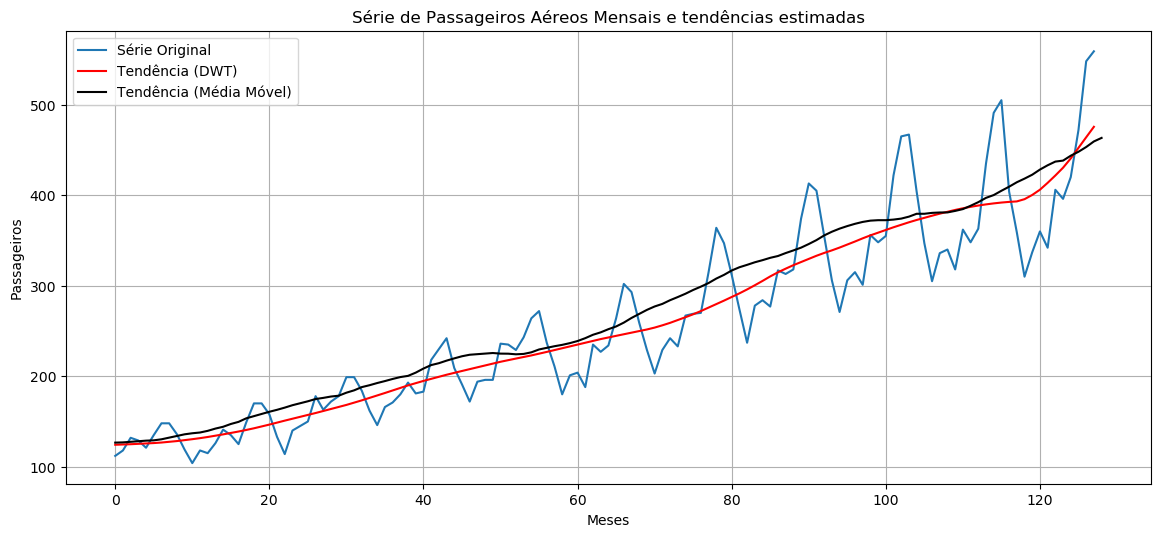

In [36]:
#Carrega a série de dados temporais
df = pd.read_csv('exemplos/AirPassengers.csv')
serie_air = df['#Passengers'][:128]

wavelet = pywt.Wavelet('db4')
level   = 4 #entre 8 e 16 meses
coeffs  = pywt.wavedec(serie_air, wavelet, level=level)

#Sintetiza (reconstrói) a série sem os coeficientes de detalhes
for j in range(1, len(coeffs)):
    coeffs[j] *= 0
    
serie_rec = pywt.waverec(coeffs, wavelet)

'''
Implementa uma média móvel apenas para comparação
'''
wz = 12 #tamanho da janela de análise
mv = pd.Series(df['#Passengers']).rolling(wz).mean().tolist()
mv = mv[wz - 1: 128 + wz]


#exibe a série original e a serie reconstruída, que representa a tendência da série original, 
#pois esta é a componente de baixa frequência
plt.figure(dpi=100,figsize=(14,6))
ax = plt.subplot(111)
ax.plot(serie_air, label='Série Original')
ax.plot(serie_rec, label='Tendência (DWT)', color='red')
ax.plot(mv, label='Tendência (Média Móvel)', color='k')
ax.set_title('Série de Passageiros Aéreos Mensais e tendências estimadas')
ax.set_ylabel('Passageiros')
ax.set_xlabel('Meses')
plt.legend()
plt.grid()
plt.show()

<h2>Removendo a tendência da série</h2>
<p>Ao remover a tendência da série a componente sazonal pode ser destacada</p>

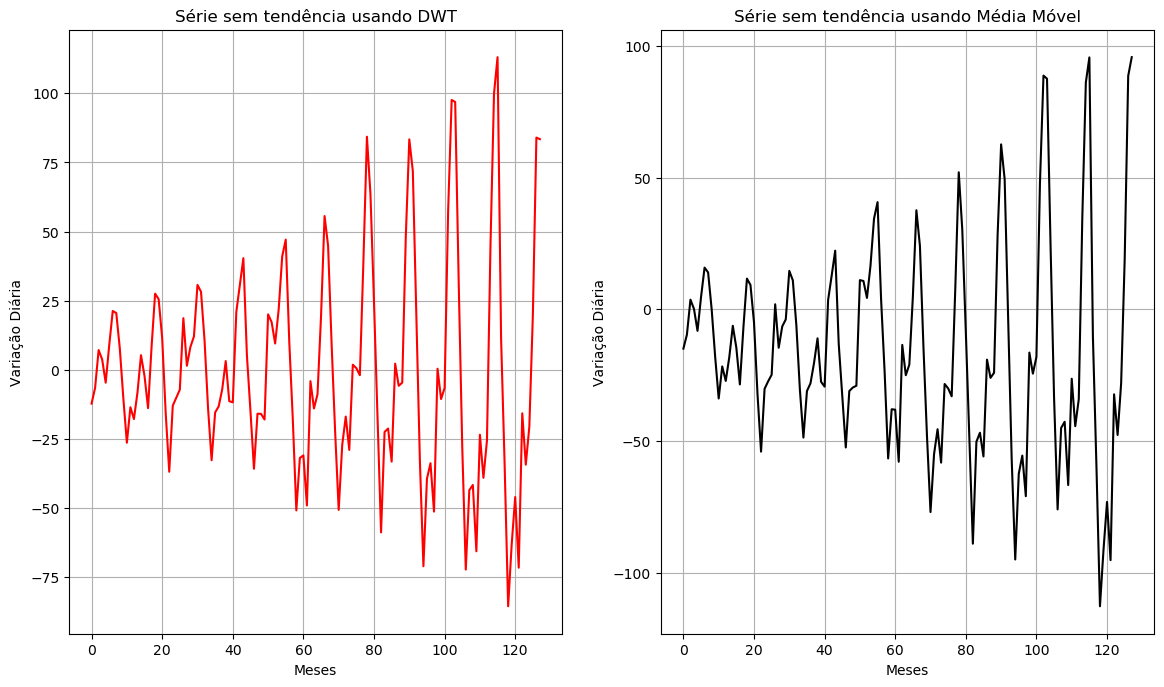

In [27]:
#Remove utilizando a curva de tendência DWT
sem_tendencia_DWT = serie_air - serie_rec

#Remove utilizando a curva de tendência obtida pela Média Móvel
sem_tendencia_MV = serie_air - mv[1:]

plt.figure(dpi=100,figsize=(14,8))
plt.subplot(121)
plt.plot(sem_tendencia_DWT, color='r')
plt.title('Série sem tendência usando DWT')
plt.ylabel('Variação Diária')
plt.xlabel('Meses')
plt.grid()
plt.subplot(122)
plt.plot(sem_tendencia_MV, color='k')
plt.title('Série sem tendência usando Média Móvel')
plt.ylabel('Variação Diária')
plt.xlabel('Meses')
plt.grid()
plt.show()

<h4>Referências</h4>
<ul>
    <li>Uzinski, Julio Cezar; Oliveira, Bruno Rodrigues de; Abreu, Caio Cesar Enside de. Obtenção de Tendências em Série Temporal empregando a Transformada Wavelet e o filtro Savitzky-Golay.In: Aplicações de Inteligência Artificial e Ciência de Dados, Nova Xavantia: Pantnal, 2020. DOI: https://doi.org/10.46420/9786588319260cap1 </li>
    <li>Oliveira, Bruno Rodrigues de; Duarte, Marco Aparecido Queiroz; Abreu, Caio Cesar Enside de; Vieira Filho, Jozue. (2018). A wavelet-based method for power-line interference removal in ECG signals. Research on Biomedical Engineering, 34(1), 73-86. DOI: https://doi.org/10.1590/2446-4740.01817</li>
    <li>D.L. Donoho and I.M. Johnstone. Ideal Spatial Adaptation via Wavelet Shrinkage. Biometrika. Vol. 81, No. 3, pp.425-455, 1994. DOI: https://doi.org/10.1093/biomet/81.3.425</li>
    <li>A. Bruce and H-Y. Gao. WaveShrink: Shrinkage Functions and Thresholds. Proc. SPIE 2569, Wavelet Applications in Signal and Image Processing III, 1995. DOI: https://doi.org/10.1117/12.217582</li>
</ul>